In [1]:
import sys
import numpy as np
from numpy import dot, arccos, clip
from numpy.linalg import norm
from scipy.linalg import solve_lyapunov
import matplotlib.pyplot as plt

sys.path.extend(['./../lib'])
from solver import Solver

In [2]:
def f0(x, t):
    return -A  @ x

def f1(x, t):
    return -A @ np.ones(x.shape)

def r0(x):
    a = 2. * s
    r = np.exp(-np.sum(x*x, axis=0) / a) / (np.pi * a)**(d/2)
    return r.reshape(-1)

def rs(x):
    r = np.exp(-0.5 * np.diag(x.T @ Wi @ x))
    r/= np.sqrt(2**d * np.pi**d * np.abs(Wd))
    return r
    
d = 2
s = 0.1
D = 0.5
A = np.array([
    [1.0, 1.],
    [0., 2.0],
])
W = solve_lyapunov(A, 2. * D * np.eye(d))
Wi = np.linalg.inv(W)
Wd = np.linalg.det(W)

In [9]:
SL = Solver(d=d, eps=1.E-6, with_tt=False)
SL.set_funcs(f0, f1, r0, None, rs)
SL.set_coefs(D)
SL.set_grid_t(200, 0., 5., t_hst=10)
SL.set_grid_x(61, -3., 3.)

SL._calc_rhs(t=100., is_stat=True)

|| rhs_stat || / || rho_stat || = 9.60e-14


In [10]:
SL.prep()
SL.calc()
SL.info()
SL._calc_rhs()

Solve: 100%|███| 199/199 [00:30<00:00,  6.68step/s, | At T=5.0e+00 : es=1.5e+02]


----------- Solver
Format    : 2D, NP [order=2]
Grid t    : poi =       200, min =    0.0000, max =    5.0000
Grid x    : poi =        61, min =   -3.0000, max =    3.0000
Time sec  : prep = 1.38e-01, calc = 2.96e+01, spec = 6.43e-01
Err stat  : 1.47e+02
|| rhs_stat || / || rho_stat || = 4.19e-03


Norm calc : 3.67e+02
Norm stat : 4.75e+00
Angle cos : 7.96e-01
Angle phi : 6.50e-01


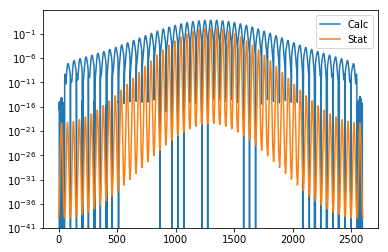

In [15]:
r_calc = SL.comp(SL.IT.grid()).reshape(-1, order='F')
r_stat = SL.func_r0(SL.IT.grid()).reshape(-1, order='F')

c = dot(r_calc, r_stat) / norm(r_calc) / norm(r_stat)
a = arccos(clip(c, -1, 1))

print('Norm calc : %-8.2e'%norm(r_calc))
print('Norm stat : %-8.2e'%norm(r_stat))
print('Angle cos : %-8.2e'%c)
print('Angle phi : %-8.2e'%a)

x = np.arange(r_calc.size)
plt.plot(x, r_calc, label='Calc')
plt.plot(x, r_stat, label='Stat')
plt.legend(loc='best')
plt.semilogy()
plt.show()

Norm calc : 2.67e+00
Norm stat : 4.75e+00
Angle cos : 8.17e-01
Angle phi : 6.15e-01


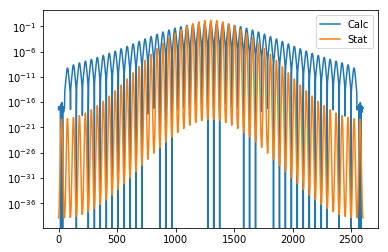

In [12]:
r_calc = SL.comp(SL.IT.grid()).reshape(-1, order='F')
r_stat = SL.func_r0(SL.IT.grid()).reshape(-1, order='F')

c = dot(r_calc, r_stat) / norm(r_calc) / norm(r_stat)
a = arccos(clip(c, -1, 1))

print('Norm calc : %-8.2e'%norm(r_calc))
print('Norm stat : %-8.2e'%norm(r_stat))
print('Angle cos : %-8.2e'%c)
print('Angle phi : %-8.2e'%a)

x = np.arange(r_calc.size)
plt.plot(x, r_calc, label='Calc')
plt.plot(x, r_stat, label='Stat')
plt.legend(loc='best')
plt.semilogy()
plt.show()

In [7]:
from intertrain import Intertrain

t_min, t_max, t_poi = +0., +5., 200
x_min, x_max, x_poi = -3., +3., 91

IT = Intertrain(n=[x_poi]*d, l=[[x_min, x_max] for _ in range(d)], with_tt=False)
IT.init(rs)

I0 = np.eye(x_poi)
D1 = IT.dif1()
D2 = IT.dif2()

t = 100.
x = IT.grid()
f = f0(x, t)
r = IT.Y.reshape(-1, order='F')

rhs = 0.
for k in range(d):
    M = [I0.copy() for _ in range(d)]
    
    M[d-1-k] = D1.copy(); _D1 = M[0].copy()
    for k_ in range(1, d): _D1 = np.kron(_D1, M[k_])
        
    M[d-1-k] = D2.copy(); _D2 = M[0].copy()
    for k_ in range(1, d): _D2 = np.kron(_D2, M[k_])

    rhs-= _D1 @ (r * f[k, :])
    rhs+= _D2 @ (r * D)

J0 = np.eye(x_poi); J0[0, 0] = 0.; J0[-1, -1] = 0.; J = J0.copy()
for _ in range(1, d): J = np.kron(J, J0)
rhs = J @ rhs

n_rho = np.linalg.norm(r)
n_rhs = np.linalg.norm(rhs)
e = n_rhs / n_rho
print('|| rhs_stat || / || rho_stat || = %-8.2e'%e)

|| rhs_stat || / || rho_stat || = 1.52e-13


In [ ]:
rhs = D_coef * np.kron(D2, np.kron(I0, I0)) @ r
rhs+= D_coef * np.kron(I0, np.kron(D2, I0)) @ r
rhs+= D_coef * np.kron(I0, np.kron(I0, D2)) @ r
rhs-= np.kron(D1, np.kron(I0, I0)) @ (f[0, :] * r)
rhs-= np.kron(D1, np.kron(D1, I0)) @ (f[1, :] * r)
rhs-= np.kron(I0, np.kron(I0, D1)) @ (f[2, :] * r)
rhs = np.kron(J0, np.kron(J0, J0)) @ rhs

In [2]:
def f0(x, t):
    return -A  @ x

def f1(x, t):
    return -A @ np.ones(x.shape)

def r0(x):
    a = 2. * s
    r = np.exp(-np.sum(x*x, axis=0) / a) / (np.pi * a)**(d/2)
    return r.reshape(-1)

def rs(x):
    r = np.exp(-0.5 * np.diag(x.T @ Wi @ x))
    r/= np.sqrt(2**d * np.pi**d * np.abs(Wd))
    return r
    
d = 2
s = 10.
D = 0.5
A = np.array([
    [1.0, 0.7],
    [0.5, 2.0],
])
W = solve_lyapunov(A, 2. * D * np.eye(d))
Wi = np.linalg.inv(W)
Wd = np.linalg.det(W)

In [3]:
SL = Solver(d=d, eps=1.E-6, with_tt=False)
SL.set_funcs(f0, f1, r0, None, rs)
SL.set_coefs(D)
SL.set_grid_t(500, 0., 5., t_hst=10)
SL.set_grid_x(51, -3., 3.)
SL.prep()
SL.calc()
SL.info()

Solve: 100%|███| 499/499 [00:57<00:00,  8.09step/s, | At T=5.0e+00 : es=1.6e+02]

----------- Solver
Format    : 2D, NP [order=2]
Grid t    : poi =       500, min =    0.0000, max =    5.0000
Grid x    : poi =        51, min =   -3.0000, max =    3.0000
Time sec  : prep = 1.29e-01, calc = 5.73e+01, spec = 6.97e-01
Err stat  : 1.59e+02


In [8]:
r_calc = SL.comp(SL.IT.grid()).reshape(-1, order='F')
r_stat = SL.func_r0(SL.IT.grid()).reshape(-1, order='F')

c = dot(r_calc, r_stat) / norm(r_calc) / norm(r_stat)
a = arccos(clip(c, -1, 1))

print('Norm calc : %-8.2e'%norm(r_calc))
print('Norm stat : %-8.2e'%norm(r_stat))
print('Angle cos : %-8.2e'%c)
print('Angle phi : %-8.2e'%a)

x = np.arange(r_calc.size)
plt.plot(x, r_calc, label='Calc')
plt.plot(x, r_stat, label='Stat')
plt.legend(loc='best')
plt.semilogy()
plt.show()

Norm calc : 1.09e+00
Norm stat : 5.40e-01
Angle cos : 3.29e-01
Angle phi : 1.24e+00


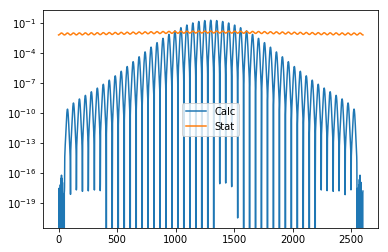